In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import KernelPCA
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


PCA

In [2]:
combined_df_no_nans = pd.read_parquet("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/total_df_no_nans_and_labels.parquet")

In [3]:
#remove coordinates, labels, and desired features after correlation analysis
combined_df = combined_df_no_nans.drop(columns=['x', 'y','labels', 'chlor_a_10th_percentile', 'sediment_nitrate_mean',
                                               'sediment_nitrate_90th_percentile', 'temperature_max', 'salinity_10th_percentile', 'salinity_90th_percentile',
                                               'current_speed_90th_percentile', 'chlor_a_90th_percentile', 'sediment_silicate_mean'])

In [4]:
print(combined_df.columns)

Index(['bathymetry', 'slope', 'fine_BPI_std', 'broad_BPI_std',
       'log_ruggedness', 'aspect_cos', 'aspect_sin', 'temperature_min',
       'temperature_mean', 'salinity_mean', 'current_speed_mean',
       'statistical_northness', 'statistical_eastness', 'current_aspect_angle',
       'chlor_a_mean', 'sediment_nitrate_10th_percentile',
       'sediment_silicate_10th_percentile',
       'sediment_silicate_90th_percentile'],
      dtype='object')


In [32]:
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(combined_df)

In [33]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

In [7]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in pca_df.columns:
        print(f"{col_name}: {pca.components_[i][pca_df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 91.62%
PC1: -0.07118336856365204
PC2: 0.010950309224426746
PC3: 0.0012604065705090761
PC4: -0.0016446963418275118


Principal Component 2: 1.34%
PC1: 0.08039459586143494
PC2: 0.3057388961315155
PC3: 0.6353904008865356
PC4: 0.658502459526062


Principal Component 3: 1.24%
PC1: -0.02866227552294731
PC2: 0.32032084465026855
PC3: -0.15707600116729736
PC4: -0.1882144808769226


Principal Component 4: 1.23%
PC1: 0.11243680864572525
PC2: -0.44735854864120483
PC3: 0.15992330014705658
PC4: 0.21267858147621155




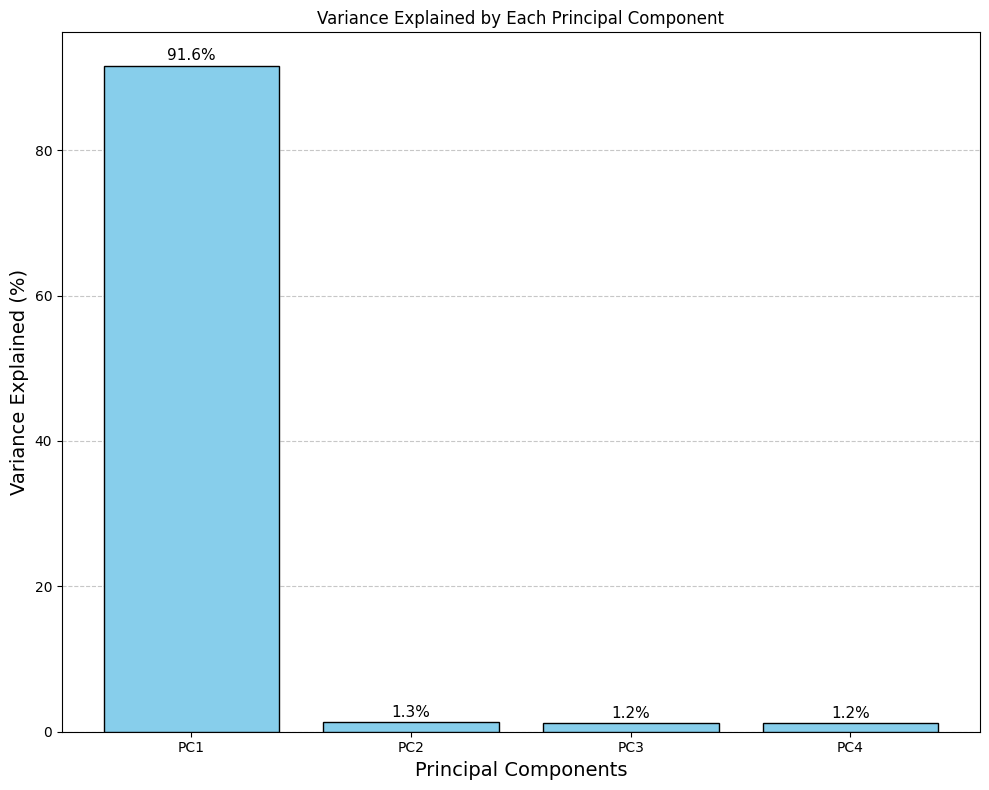

In [8]:
pca_variance = [91.62, 1.34, 1.24, 1.23]
components = [f'PC{i+1}' for i in range(len(pca_variance))]

plt.figure(figsize=(10, 8))
bars = plt.bar(components, pca_variance, color='skyblue', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

for bar in bars:
    bar.set_zorder(3)

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Variance Explained by Each Principal Component')

for i, v in enumerate(pca_variance):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("PCA_variance_each_component_pipeline_1.png", dpi=300)

plt.show()


In [9]:
loadings = pca.components_.T 

loading_df = pd.DataFrame(loadings, index=combined_df.columns, 
                          columns=[f'PC{i+1}' for i in range(loadings.shape[1])])


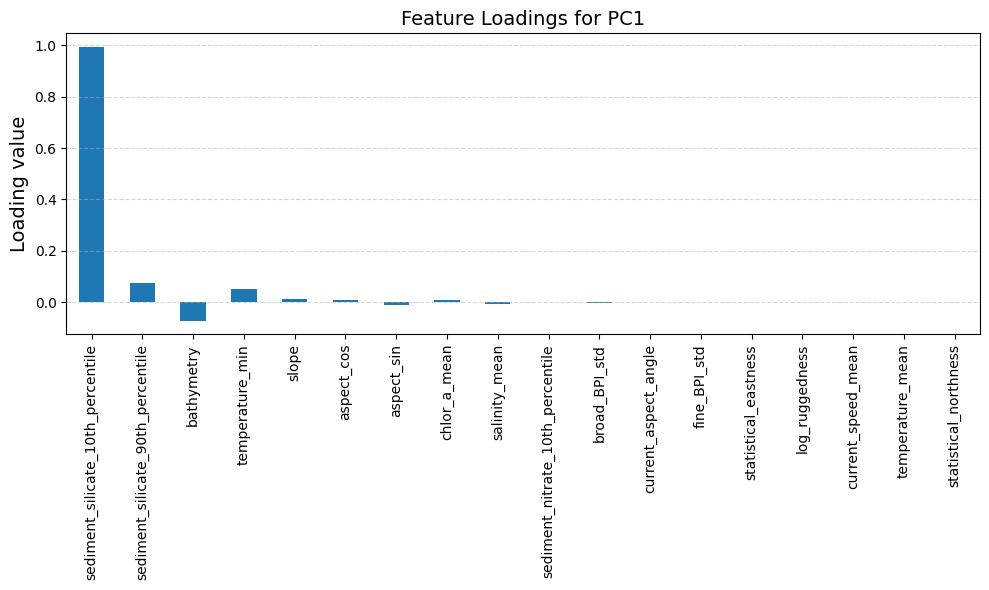

In [10]:
pc1_loadings = loading_df['PC1'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc1_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC1", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


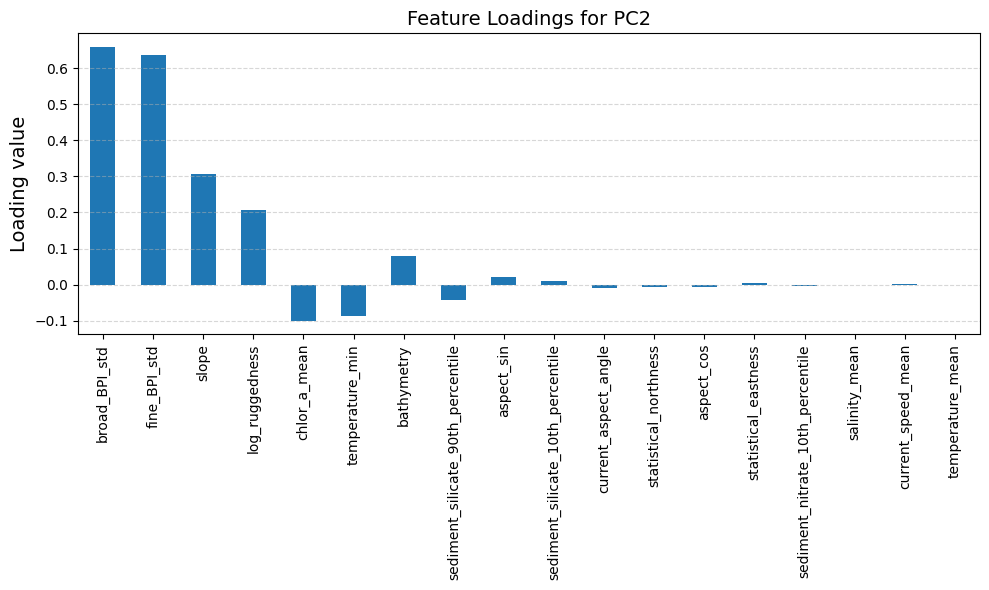

In [12]:
pc2_loadings = loading_df['PC2'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc2_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC2", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


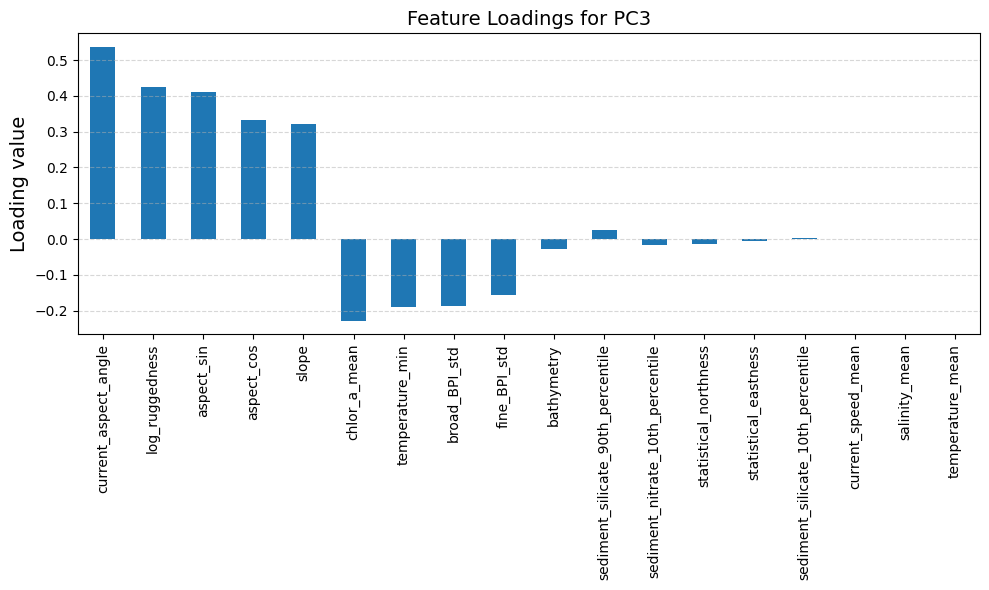

In [13]:
pc3_loadings = loading_df['PC3'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc3_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC3", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [34]:

import pickle
with open("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/pca_features.pkl", "wb") as f:
    pickle.dump(pca_df, f)


#To use later:
#with open("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/pca_features.pkl", "rb") as f:
    #pca_df = pickle.load(f)



PLS

In [15]:
X = combined_df
y = combined_df_no_nans[['labels']]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
pls = PLSRegression(n_components=2)
pls.fit(X_train, Y_train)

PLSRegression()

In [18]:
X_scores, Y_scores = pls.transform(X_train), pls.predict(X_train)

In [19]:
Y_train_pred = pls.predict(X_train)
Y_test_pred = pls.predict(X_test)

#Explained variance
print("X Loadings:", pls.x_loadings_)
print("Y Loadings:", pls.y_loadings_)

X Loadings: [[-0.4240097  -0.37968774]
 [-0.10504158  0.51796432]
 [-0.07113898  0.14783319]
 [-0.07023717  0.00953446]
 [-0.12910166  0.22526523]
 [ 0.17505157 -0.16710861]
 [-0.05227141 -0.22732343]
 [ 0.45063243  0.11521903]
 [-0.02668459  0.04643704]
 [-0.27660148 -0.22802799]
 [-0.19773797 -0.10276782]
 [ 0.07898343  0.00827965]
 [-0.11049713  0.61232522]
 [-0.01182612  0.06183919]
 [ 0.15584507 -0.00121599]
 [ 0.26260216 -0.13574367]
 [ 0.51764971  0.27454784]
 [ 0.48105378  0.42491592]]
Y Loadings: [[-0.0033125   0.00293953]]


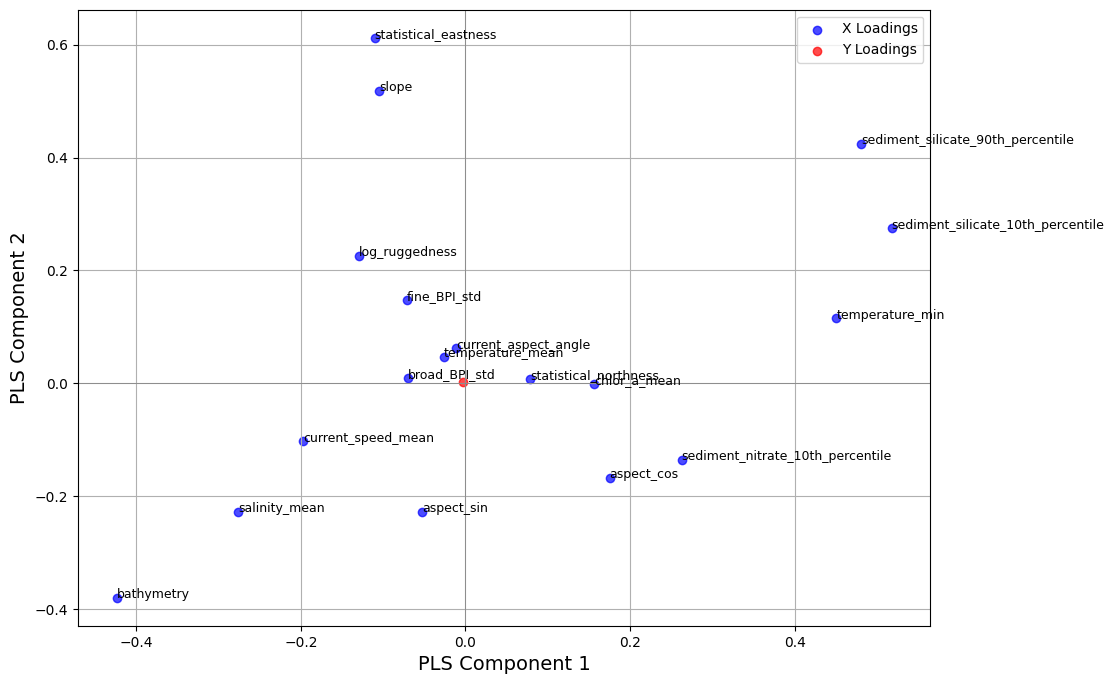

In [21]:
loadings_X = pls.x_loadings_
loadings_Y = pls.y_loadings_

plt.figure(figsize=(11, 8))
plt.scatter(loadings_X[:, 0], loadings_X[:, 1], label='X Loadings', color='blue', alpha=0.7)
plt.scatter(loadings_Y[:, 0], loadings_Y[:, 1], label='Y Loadings', color='red', alpha=0.7)

for i, feature in enumerate(X_train.columns):
    plt.text(loadings_X[i, 0], loadings_X[i, 1], feature, fontsize=9)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("PLS Component 1", fontsize=14)
plt.ylabel("PLS Component 2", fontsize=14)
#plt.title("PLS Loading Plot", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

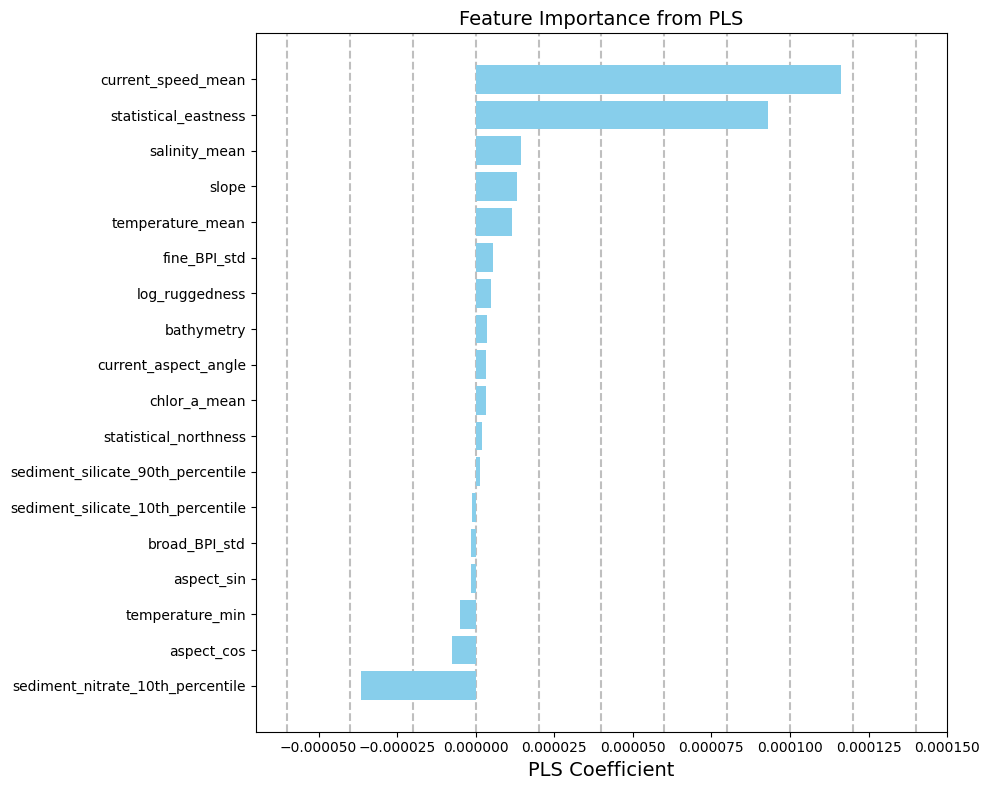

In [22]:
import matplotlib.pyplot as plt
import numpy as np

features = X.columns
coefficients = pls.coef_.ravel()

sorted_indices = np.argsort(coefficients)[::-1]
sorted_features = features[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color="skyblue")
xticks = plt.xticks()[0]
for x in xticks:
    plt.axvline(x=x, linestyle='--', color='gray', alpha=0.5, zorder=0)
plt.title("Feature Importance from PLS", fontsize=14)
plt.xlabel("PLS Coefficient", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout() 
plt.show()

In [31]:
X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)

with open("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/PLS/X_train_pls.pkl", "wb") as f:
    pickle.dump(X_train_pls, f)

with open("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/PLS/X_test_pls.pkl", "wb") as f:
    pickle.dump(X_test_pls, f)

Y_train.to_csv("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/PLS/Y_train.csv", index=False)
Y_test.to_csv("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/PLS/Y_test.csv", index=False)


Kernel PCA 

In [35]:
feature_map = Nystroem(kernel='rbf', gamma=0.1, n_components=50)
X_mapped = feature_map.fit_transform(combined_df)

pca = PCA(n_components=9)
#pca = PCA(n_components=0.95)
X_kpca_approx = pca.fit_transform(X_mapped)

In [36]:
kernel_pca_df = pd.DataFrame(data=X_kpca_approx, columns=[f'PC{i+1}' for i in range(X_kpca_approx.shape[1])])

In [25]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in pca_df.columns:
        print(f"{col_name}: {pca.components_[i][pca_df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 24.28%
PC1: -0.13113772869110107
PC2: 0.0071943942457437515
PC3: -0.0076629058457911015
PC4: 0.15816763043403625
PC5: 0.0005124682211317122
PC6: 0.3491160273551941
PC7: 0.21301746368408203
PC8: 0.003050507977604866
PC9: -0.19094695150852203


Principal Component 2: 9.42%
PC1: -0.21727660298347473
PC2: 0.0008209096267819405
PC3: -0.004065193235874176
PC4: -0.00804378092288971
PC5: 0.009807268157601357
PC6: -0.02941744029521942
PC7: -0.0170080978423357
PC8: 0.012323768809437752
PC9: -0.3219568729400635


Principal Component 3: 8.44%
PC1: 0.004040510859340429
PC2: -0.016685988754034042
PC3: -0.0002841430250555277
PC4: -0.13282965123653412
PC5: 0.02157731167972088
PC6: 0.32795777916908264
PC7: 0.35434043407440186
PC8: 0.026261545717716217
PC9: 0.009482328779995441


Principal Component 4: 7.52%
PC1: 0.008975787088274956
PC2: -0.012894591316580772
PC3: -0.0007865178631618619
PC4: 0.39736276865005493
PC5: -0.016852455213665962
PC6: -0.2982548177242279
PC7: 0.0044080498

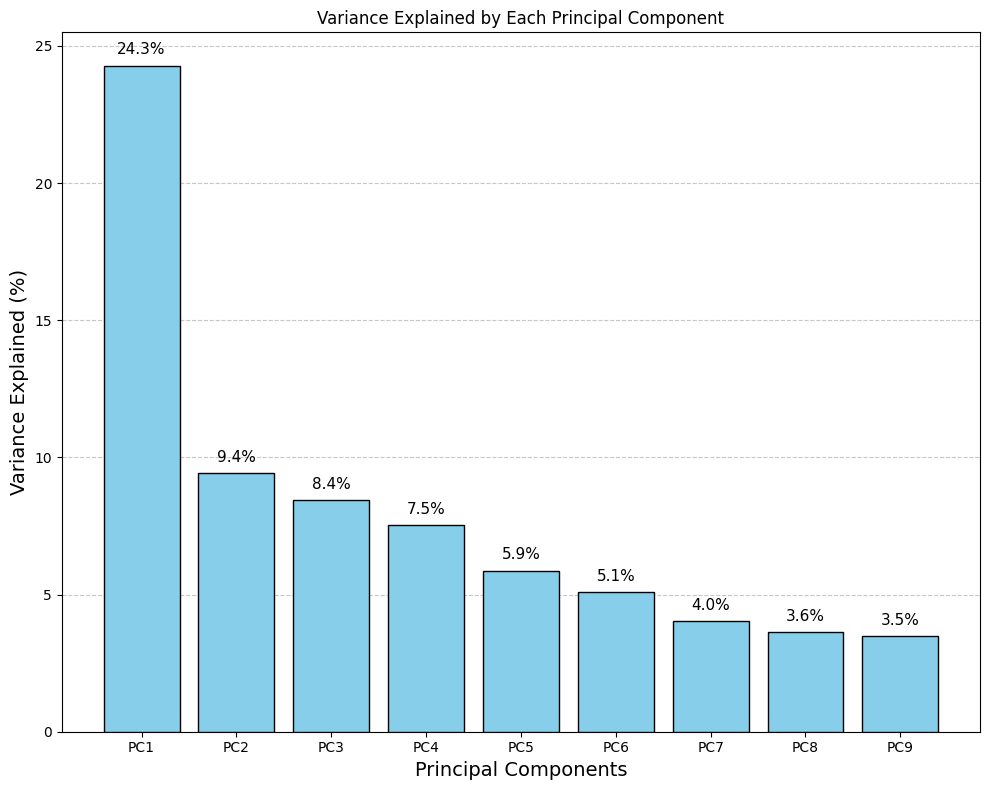

In [26]:
pca_variance = [24.28, 9.42, 8.44, 7.52, 5.87, 5.09, 4.03, 3.62, 3.48]
components = [f'PC{i+1}' for i in range(len(pca_variance))]

plt.figure(figsize=(10, 8))
bars = plt.bar(components, pca_variance, color='skyblue', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

for bar in bars:
    bar.set_zorder(3)

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Variance Explained by Each Principal Component')

for i, v in enumerate(pca_variance):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("PCA_variance_each_component_pipeline_1.png", dpi=300)

plt.show()

In [37]:

import pickle
with open("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/kernel_pca_features.pkl", "wb") as f:
    pickle.dump(kernel_pca_df, f)


#To use later:
#with open("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_6/kernel_pca_features.pkl", "rb") as f:
    #pca_df = pickle.load(f)

